In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import qutip as qt
import math as math
from qutip.qip.operations import hadamard_transform
from functools import reduce

from IPython.display import Image
from IPython.core.display import HTML 

# Grover's Algorithm 

## Introduction
In this assignment our goal is to expand on the quantum search algorithm devised by Lov Grover in 1996. We will address the classical problem solved by the algorithm, additionally we will elaborate on the physics behind the algorithm and lastly we will discuss its advantages over classical search algorithms. We will also provide Python code where we implement Grover's algorithm and we will comment on its expected success in retrieving entries from large data sets. [1]

Authors:

Anastasios Mavridis & Jess Lonsdale
(Note this code is hosted on one of our personal github pages, if for any reason you have issues running this file there is a saved version on a final runthrough visible here. Also some graphs of larger problems we chose to not include here for the sake of runtime. 🙂 https://github.com/jlonsdale/grovers-algo/blob/main/grovers%20algorithm.ipynb)

## The Classical Problem
Typically when one has to find a specific object that lies in a large array of objects, the standard procedure is to explicitly check all of them one by one. Say for instance that we are interested in a specific telephone number's owner. What we would do is to get a telephone book or more generally a telephone directory and start comparing our entry to all of the entries in the book, one at a time. Statistics dictates that on average we are going to need N/2 tries which we will from now on call queries, before we will find the correct entry. 

Time complexity is a representation of the time taken by an algorithm to solve a problem as a function relative to the size of the input data. This property is commonly expressed in $\mathcal{O}$ ("Big O") notation which represents the upper bound of the number of steps needed to solve the problem. 

In the context of quantum computing, Grover's algorithm seeks to find a particular element with $\mathcal{O}(\sqrt{N})$ time complexity by utilising quantum entanglement to solve this classical problem faster than the classical method described above. [3], [1]

## The Quantum Algorithm 


- Firstly let's quantify the classical problem. Given a classical array of N objects, we seek to find the placement of one of them, meaning that we know the value of that $a_i$ which implies that we can distinguish it from the others, but not its placement $i$, which will be the incentive in our inquiry. We will assign a quantum state indexed by the placement number (written in base 2) to each of the entries.

    $$\{a_1,a_2, .. ,a_i, .. ,a_N\}\rightarrow \{\vert 1 \rangle,\vert 10 \rangle,\vert 11 \rangle,..,\vert 10^n \rangle\} \tag{Equation 1}$$   

    $$N=2^{n}$$


- We can be more rigorous by introducing this Boolean function (also sometimes refered to as an oracle):

    $$f: \{0,1\}^n \rightarrow \{0,1\}$$

    \begin{equation}
    f_{x_0}(x) = \delta_{x,x_0} \tag{Equation 2}
    \end{equation} 

    where $x_0$ would be the binary string corresponding to the placement $i$ that we are trying to determine through this algorithm. [4]       
    
![fig1](https://raw.githubusercontent.com/jlonsdale/grovers-algo/main/2.png) 


Figure 1: Circuit for the Grover iteration [3]

- In the next step we will prepare an equal weight uniform superposition. In order to create such superposition we begin from N different qubits, all of which are in the down state $\vert 0 \rangle$. We then apply on each one of them the Hadamard operator and subsequently take their tensor product. What we come to realise is that by expanding the tensor product we can obtain an entantangled uniform superposition. 

    We then have one last step to go. Every term in this superposition is specified by a binary number which we will use to index the superposition. For example, $\vert 0...10 \rangle$ can be specified by the binary number $x=2$. Since all binary numbers from $x=0$ to $x=2^n -1$ appear with the same coefficient we can write:

    $$\vert \psi \rangle = H^{\otimes n} \vert 0 \rangle^{\otimes n} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \vert x \rangle \tag{Equation 3}$$ 

    $[4],[3]$
    

- Here we will define the flip phase operator $U_{x_i}$ which flips the sign only for a specific binary indexed ket:

    \begin{equation}
    U_{x_i} \vert x_k \rangle = \left(I - 2\vert x_i \rangle\langle x_i \vert\right) \vert x_k \rangle = -\left(-1\right)^{\delta_{i,k}} \vert x_k \rangle \tag{Equation 4}
    \end{equation}

    $[2],[3]$


- Next, let us define another unitary operator $U_\psi$:

    \begin{align}
    |U_\psi &= 2\vert \psi \rangle \langle \psi \vert - I \tag{Equation 5} \\
    U_\psi &= \frac{2}{N} \sum_{x,x'} \vert x \rangle \langle x' \vert - I \tag{Equation 6}
    \end{align}

    We notice that the first term in matrix notation is a matrix with all of its entries equal to 1. That is because in the sum there exist all possible pairs with coefficient 1.

    This means that when this first term acts on an arbitrary state, since its entries are all 1, it simply outputs two times the mean in every row:

    $$\frac{2}{N}
    \begin{pmatrix}
    1 & 1 & \cdots & 1\\
    1 & 1 & \cdots & 1\\
    \vdots & \vdots & \ddots & \vdots\\
    1 & 1 & \cdots & 1
    \end{pmatrix}
    \begin{pmatrix}
    c_0\\
    c_1\\
    \vdots\\
    c_{N-1}
    \end{pmatrix}
    =2\bar{c}
    \begin{pmatrix}
    1\\
    1\\
    \vdots\\
    1
    \end{pmatrix} \tag{Equation 7}$$

    So for the action of both terms:

    $$U_\psi
    \begin{pmatrix}
    c_0\\
    c_1\\
    \vdots\\
    c_{N-1}
    \end{pmatrix}
    =
    \begin{pmatrix}
    2\bar{c}-c_0\\
    2\bar{c}-c_1\\
    \vdots\\
    2\bar{c}-c_{N-1}
    \end{pmatrix}
    =
    \begin{pmatrix}
    \bar{c}-(c_0-\bar{c})\\
    \bar{c}-(c_1-\bar{c})\\
    \vdots\\
    \bar{c}-(c_{N-1}-\bar{c})
    \end{pmatrix} \tag{Equation 8}$$

    This describes the process of inversion about the mean. In other words, the operator $U_\psi$ acts on an arbitrary state and outputs for each component the mean reduced by the distance of the corresponding component from the mean. [3],[2]
    

- It is time we put all the ingredients together. Grover's algorithm starts with the uniform superposition obtained in (3) and acts on it first by (4). What this amounts to, is having flipped the phase of the classical string $x_i$ which we are trying to allocate within the initial array (1). Afterwards we act on the state with (6) which now lowers all entries but amplifies $x_i$. We then proceed by flipping the phase of the $x_i$ string again. Now it becomes positive but substantially larger than the rest that were reduced by (6). So we have started with a uniform superposition and have made $x_i$ the predominant component of this state. If we are to iterate this procedure, all components other than the one we are searching for are greatly diminished and the superposition in the limit becomes the quantum state associated with the classical index we are looking for.



![fig2](https://raw.githubusercontent.com/jlonsdale/grovers-algo/main/1.png) 
Figure 2: Schematic circuit for the quantum search algorithm. The oracle may
employ work qubits for its implementation, but the analysis of the quantum
search algorithm involves only the n qubit register [3]

## Convergence Criteria

At the optimal number of iterations, the superposition tends to a single qubit state that corresponds to the classical base 2 string $x_0$. All we need to do is make a measurement on the superposition state, and with almost absolute certainty, we can retrieve the desired 'target' state.

If we were to perform this procedure m times, the overlap amplitude tends to:

$$\langle x_0 \vert \psi \rangle = \frac{1}{\sqrt{N}} \rightarrow \frac{2m}{\sqrt{N}} \tag{Equation 9}$$

Therefore, if we perform $m=\sqrt{N}$ queries, we can get a fast convergence on absolute certainty that the state has now become $\vert x_0 \rangle$. 

It is important to note that if we continue the algorithm for more iterations than $m$, the amplitude will drop again with a functional form $\sin^2(m)$. However we will not expand further on this.

The quantum nature of the algorithm now shows its advantage over the classical calculations, since for a large number of objects, we can easily see that $\sqrt{N} \ll \frac{N}{2}$. Consequently, Grover triumphs over classical computing. [2]


In [2]:
def generate_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle = np.random.randint(0,int(math.pow(2,length))-1)
    return (haystack[:needle]+'1'+haystack[needle + 1:]), needle

In [3]:
def generate_double_search_problem(length):
    haystack = '0' * int(math.pow(2,length))
    needle1, needle2 = np.random.choice(range(int(math.pow(2,length))), size=2, replace=False)
    haystack = haystack[:needle1]+'1'+haystack[needle1+1:]
    haystack = haystack[:needle2]+'1'+haystack[needle2+1:]
    return haystack, needle1, needle2

In [4]:
def grovers_circuit(haystack,needles):
    
    state_history = []
    
    # Calculate the number of qubits needed to represent this problem
    string_length = int(len(haystack))
    number_of_qubits = int(math.log(string_length, 2))
    
    # Initialize data qubits using list comprehension
    qubits = [qt.basis(2, 0) for _ in range(number_of_qubits)]

    # Add control qubit
    qubits.append(qt.basis(2, 1))

    # Calculate tensor product of input operators to create the initial state Q:
    Q = qt.tensor(qubits)
    
    # Apply tensor product to a list of Hadamard transform operations
    H = reduce(lambda x, y: qt.tensor(x, y), [hadamard_transform(1) for _ in range(len(qubits))])
            
    ##############################
    # 1. Phase Shifting Gate, Uf #
    ##############################
    
    # Create operator that phase shifts only the target element (position of '1')
    
    Uf = np.zeros((string_length*2, string_length*2))
    for i, q in enumerate(haystack):
        Uf[2*i:2*i+2, 2*i:2*i+2] = np.array([[1, 0], [0, 1]]) if q == '0' else np.array([[0, 1], [1, 0]])
              
    ################################
    # 2. Grover Diffusion Gate, Us #
    ################################
    
    # Create the diffusion operator 2*|s><s|-I
    
    outer_product_state = (1 / (2 ** number_of_qubits)) * np.ones([2 ** number_of_qubits, 2 ** number_of_qubits])
    Us = qt.tensor(qt.Qobj(-( qt.identity(2 ** number_of_qubits)) + 2*outer_product_state), qt.qeye(2))

    #############################################
    # 3. Run the Circuit pi/4 * sqrt(N/k) times #
    #############################################
    
    # First step, applying Hadamard operator to initial state.
    # This step is only performed once, so is not included in the following loop
    
    current_state = H * Q
    state_history.append(current_state)
    
    
    for i in range(int((math.pi/4) * math.sqrt(string_length/len(needles)))):
        current_state = Uf * current_state
        current_state = Us * current_state
        current_state = qt.Qobj(current_state)
        state_history.append(current_state)
        
    return state_history


Logging results & performance from n=2 to n=10
For the problem n = 2 & haystack_size = 4
Needle position from Grover's algorithm: 2
True needle position: 2
Success! Grovers algorithm has found the correct position.
For the problem n = 3 & haystack_size = 8
Needle position from Grover's algorithm: 5
True needle position: 5
Success! Grovers algorithm has found the correct position.
For the problem n = 4 & haystack_size = 16
Needle position from Grover's algorithm: 6
True needle position: 6
Success! Grovers algorithm has found the correct position.
For the problem n = 5 & haystack_size = 32
Needle position from Grover's algorithm: 15
True needle position: 15
Success! Grovers algorithm has found the correct position.
For the problem n = 6 & haystack_size = 64
Needle position from Grover's algorithm: 46
True needle position: 46
Success! Grovers algorithm has found the correct position.
For the problem n = 7 & haystack_size = 128
Needle position from Grover's algorithm: 66
True needle positi

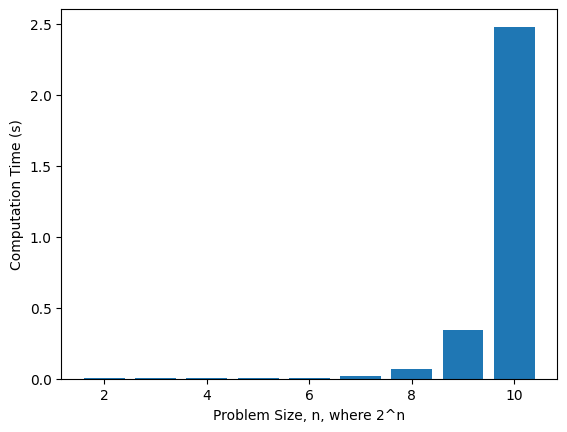

In [5]:
print("=" * 60)
print('Logging results & performance from n=2 to n=10')
computation_times = []

for n in range(2, 11):
    haystack, needle = generate_search_problem(n)
    start_time = time.time()
    current_state = np.array(grovers_circuit(haystack, [needle]).pop())
    end_time = time.time()
    result = []
    for i in range(0, len(current_state), 2):
        result.append((abs(current_state[i]) + abs(current_state[i+1]))[0])       
    needlePosFromResults = np.argmax(result)
    computation_time = end_time - start_time
    computation_times.append(computation_time)
    print("=" * 60)
    print(f"For the problem n = {n} & haystack_size = {len(haystack)}")
    print(f"Needle position from Grover's algorithm: {needlePosFromResults}")
    print(f"True needle position: {needle}")
    if needle == needlePosFromResults:
        print("Success! Grovers algorithm has found the correct position.")
    else:
        print("Failure, Grovers algorithm has found an incorrect position.")
    print("=" * 60)


plt.bar(range(2, 11), computation_times)
plt.xlabel('Problem Size, n, where 2^n')
plt.ylabel('Computation Time (s)')
plt.show()

In [6]:
print("=" * 60)
print('Logging results for a 2 needle problem')
for n in range(4, 12):
    haystack, needle1,needle2 = generate_double_search_problem(n)
    start_time = time.time()
    current_state = np.array(grovers_circuit(haystack, [needle1,needle2]).pop())
    end_time = time.time()
    result = []
    
    for i in range(0, len(current_state), 2):
        result.append((abs(current_state[i]) + abs(current_state[i+1]))[0])       
    sortedResults = np.argsort(result)[::-1]
    needlePos1 = sortedResults[0]
    needlePos2 = sortedResults[1]
    
    print("=" * 60)
    print(f"For the problem n = {n} & haystack_size = {len(haystack)}")
    print(f"Needle position from Grover's algorithm: {needlePos1} and {needlePos2}")
    print(f"True needle position: {needle1} and {needle2}")
    if ((needle1 == needlePos1 or needle1 == needlePos2) and (needle2 == needlePos2 or needle2 == needlePos1)):
        print("Success! Grovers algorithm has found the correct position.")
    else:
        print("Failure, Grovers algorithm has found an incorrect position.")
    print("=" * 60)

Logging results for a 2 needle problem
For the problem n = 4 & haystack_size = 16
Needle position from Grover's algorithm: 11 and 6
True needle position: 11 and 6
Success! Grovers algorithm has found the correct position.
For the problem n = 5 & haystack_size = 32
Needle position from Grover's algorithm: 10 and 11
True needle position: 11 and 10
Success! Grovers algorithm has found the correct position.
For the problem n = 6 & haystack_size = 64
Needle position from Grover's algorithm: 1 and 59
True needle position: 1 and 59
Success! Grovers algorithm has found the correct position.
For the problem n = 7 & haystack_size = 128
Needle position from Grover's algorithm: 65 and 86
True needle position: 65 and 86
Success! Grovers algorithm has found the correct position.
For the problem n = 8 & haystack_size = 256
Needle position from Grover's algorithm: 106 and 229
True needle position: 106 and 229
Success! Grovers algorithm has found the correct position.
For the problem n = 9 & haystack_s

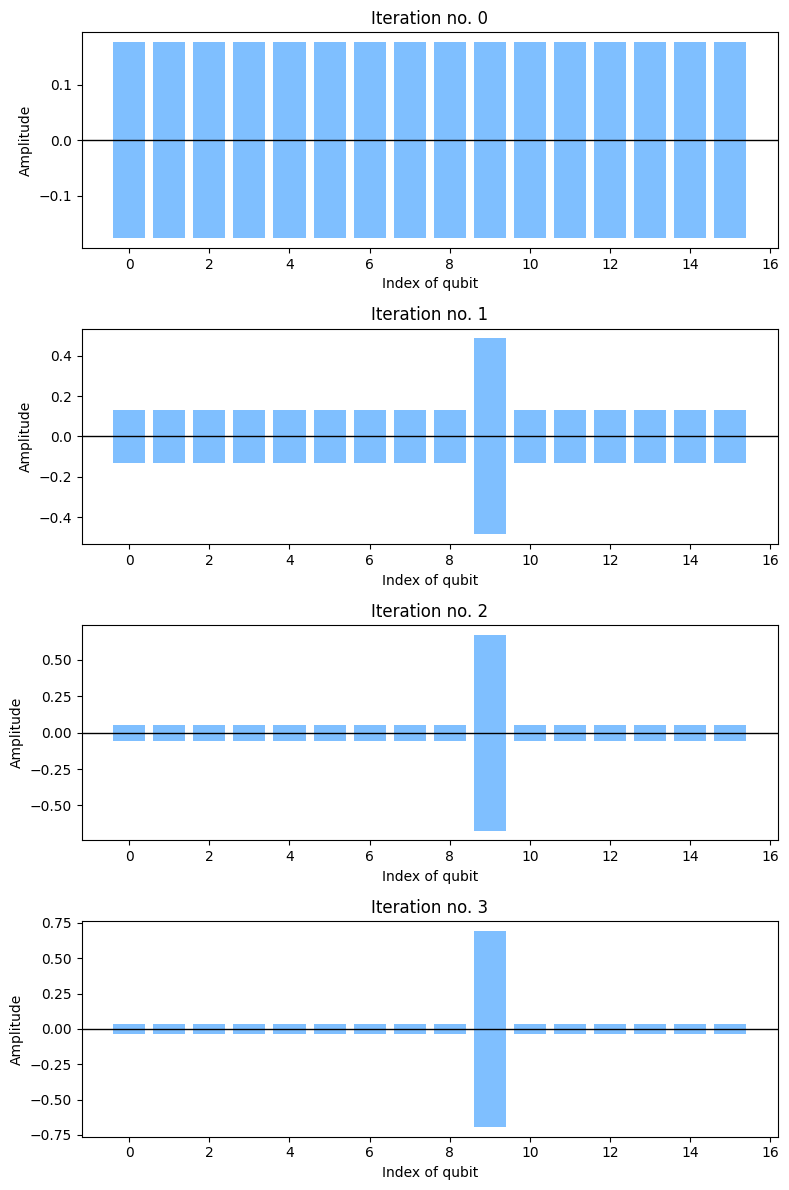

In [7]:
#Plotting how the state changes with each iteration

haystack2, needle2 = generate_search_problem(4)
state_progression = np.array(grovers_circuit(haystack2, [needle2]))

nrows = len(state_progression)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 3*nrows))

for i, data in reversed(list(enumerate(state_progression))):
    flatten_data = [[],[]]
    for j in range(0, len(data), 2):
        flatten_data[0].append(abs(data[j][0]))
        flatten_data[1].append(-abs(data[j+1][0]))
    ax = axes[i]
    ax.bar(range(len(flatten_data[0])), flatten_data[0], color='#7fbfff')
    ax.bar(range(len(flatten_data[1])), flatten_data[1], color='#7fbfff')
    ax.axhline(0, color='k', lw=1)  # Add horizontal line at y=0
    ax.set_xlabel('Index of qubit')
    ax.set_ylabel('Amplitude')
    ax.set_title('Iteration no. ' + str(i))

plt.tight_layout()
plt.show()   

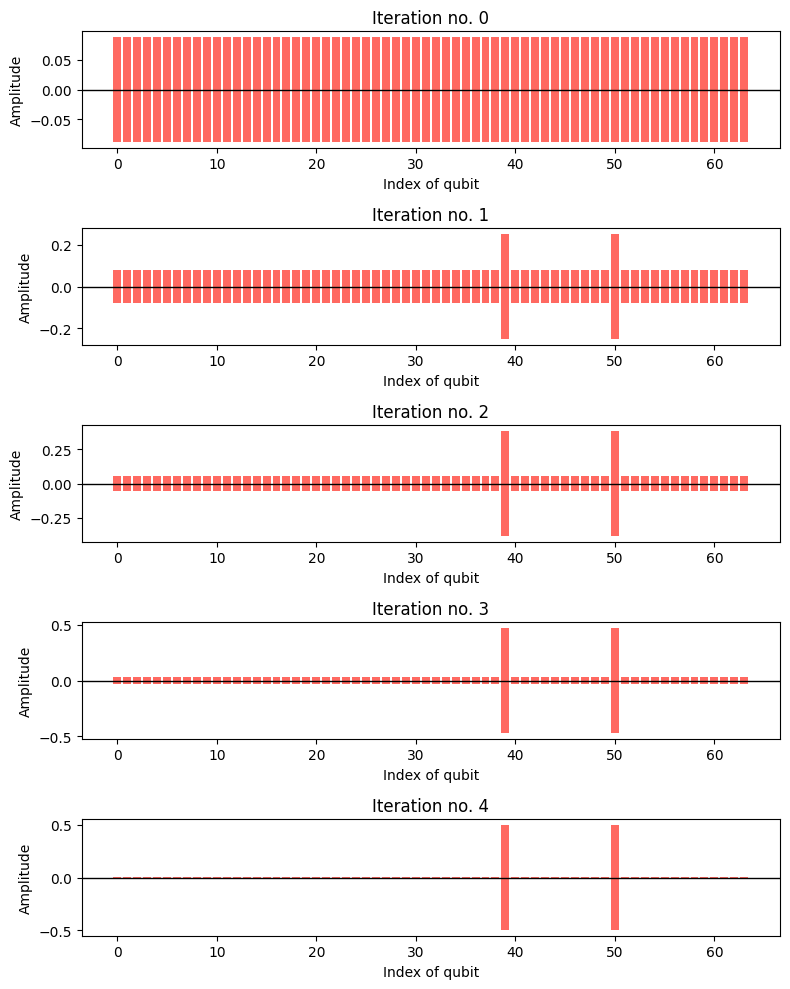

In [8]:
#Plotting how the state changes with each iteration for the DOUBLE NEEDLE PROBLEM
double_haystack, double_needle1, double_needle2 = generate_double_search_problem(6)

state_progression = np.array(grovers_circuit(double_haystack, [double_needle1, double_needle2]))

nrows = len(state_progression)
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 2*nrows))

for i, data in reversed(list(enumerate(state_progression))):
    flatten_data = [[],[]]
    for j in range(0, len(data), 2):
        flatten_data[0].append(abs(data[j][0]))
        flatten_data[1].append(-abs(data[j+1][0]))
    ax = axes[i]
    ax.bar(range(len(flatten_data[0])), flatten_data[0], color='#FF6961')
    ax.bar(range(len(flatten_data[1])), flatten_data[1], color='#FF6961')
    ax.axhline(0, color='k', lw=1)  # Add horizontal line at y=0
    ax.set_xlabel('Index of qubit')
    ax.set_ylabel('Amplitude')
    ax.set_title('Iteration no. ' + str(i))

plt.tight_layout()
plt.show()  

## Discussion

As we can see in the above test data, our implementation of Grover's algorithm finds the target qubit every single time. Each step of the Grover's operator increases the amplitude of the desired state(s) and reduces the amplitude of the other states. This code has been robustly tested for 1 and 2 needles in problem sizes ranging from $n^2$ to $n^{10}$. We can observe a steep rise in computation time for $n>10$. Therefore, this code and the framework Qutip are not viable choices for these larger problems, and custom code to efficiently handle Grover's circuit must be implemented.

In [9]:
import nbformat

# replace "X" in the filename below with your group's number
with open('grovers_algorithm.ipynb', 'r') as f:
    nb = nbformat.read(f, 4)

wordcount = 0
replacements = [('# ', ''), ('* ', ''), ('- ', '')]
for cell in nb['cells']:
    if cell['cell_type'] == 'markdown':
        source = cell['source']
        for rep in replacements:
            source = source.replace(*rep)
        # print(source.split())   # uncomment if you want to see the counted words
        wordcount += len(source.split())
print("Total word count in Markdown cells:", wordcount)

Total word count in Markdown cells: 1502


# References

1. Scott Aaronson. Introduction to Quantum Information Science -- Lecture Notes, 1994.

2. J. Eisert and M.M. Wolf. Quantum computing. In Handbook of Nature-Inspired and Innovative Computing, 2006. [Online]. Available: https://arxiv.org/abs/quant-ph/0401019v3

3. Michael A. Nielsen and Isaac L. Chuang. Quantum Computation and Quantum Information, 2010.

4. John Preskill. Quantum Information - Chapter 6. Quantum Algorithms, 2020.
